In [0]:
!rm -rf data/StanfordDogsData

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode
# cuda = torch.device('cuda')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [0]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [0]:
data_dir = "data/"

In [11]:
from data.load_data import load_datasets
train_dataset, val_dataset, test_dataset, classes = load_datasets(data_dir)
class_names = train_dataset.classes
print(len(class_names))

dataset_sizes = {"train": len(train_dataset), "val": len(val_dataset)}


Training set stats:
9600 samples spanning 120 classes (avg 80.000000 per class)
Validation set stats:
2400 samples spanning 120 classes (avg 20.000000 per class)
Testing set stats:
8580 samples spanning 120 classes (avg 71.500000 per class)
120


In [0]:
kwargs = {'num_workers': 1, 'pin_memory': True}
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset,
                 batch_size=batch_size, shuffle=True, **kwargs)
val_loader = torch.utils.data.DataLoader(val_dataset,
                 batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset,
                 batch_size=batch_size, shuffle=True, **kwargs)
dataloaders = {"train": train_loader, "val": val_loader}

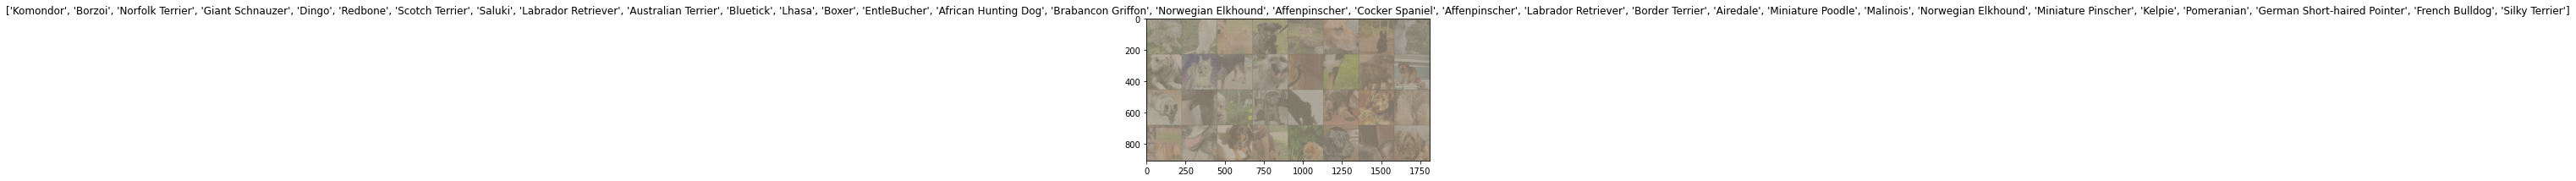

In [13]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
def evaluate(model, optimizer, criterion):
    model.eval()
    running_loss = 0
    running_corrects = 0
    n_examples = 0
    with torch.no_grad():
        
        model.eval()   # Set model to evaluate mode

        for inputs, labels in test_loader:
        
          inputs = inputs.to(device)
          # inputs = inputs.cuda()
          labels = labels.to(device)
          # labels = labels.cuda()

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward
          # track history if only in train
          with torch.set_grad_enabled(False):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

          # statistics
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)
          n_examples += preds.size(0)

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = 100. * running_corrects.double() / len(test_dataset)
    running_loss /= n_examples
    return running_loss, running_corrects, n_examples, epoch_acc

In [0]:
def train_model(model, model_name, criterion, optimizer, scheduler, hp_info, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    file_name = "{model_name}.log"
    file_name = file_name.format(model_name=model_name, lr=hp_info['lr'], momentum=hp_info['momentum'])
    log_file = open(file_name, 'w')
    
    print('-'*10)
    print('learning rate: {}, momentum: {}'.format(hp_info['lr'], hp_info['momentum']))

    for epoch in range(num_epochs):
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)

        # Each epoch has a training and validation phase
        log_file_string = ""
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                # inputs = inputs.cuda()
                labels = labels.to(device)
                # labels = labels.cuda()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            
            if phase == 'train':
                log_file_string = 'Train Epoch: {}\t Train Loss: {:.6f}\t Train Acc:{}\t '.format(epoch, epoch_loss, epoch_acc)
            else:
                log_file_string += 'Val Loss: {}\t Val Acc: {}\n'.format(epoch_loss, epoch_acc)
                log_file.write(log_file_string)
                print(log_file_string)
            # log_file.write(log_file_string)
            # print(log_file_string)

            # print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            #     phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        # print()

    time_elapsed = time.time() - since
    # print('Training complete in {:.0f}m {:.0f}s'.format(
    #     time_elapsed // 60, time_elapsed % 60))
    # print('Best val Acc: {:4f}'.format(best_acc))  

    # load best model weights
    model.load_state_dict(best_model_wts)

    test_loss, test_correct, test_n_examples, test_acc = evaluate(model, optimizer, criterion)
    log_file_string = '\ntest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
    log_file_string = log_file_string.format(test_loss, test_correct, test_n_examples, test_acc)
    log_file.write(log_file_string)
    print(log_file_string)

    log_file.close()

    return model, test_acc, best_acc


In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    sm = nn.Softmax()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            # print(nn.Softmax()(outputs[0]))
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')

                prob_dist = sm(outputs[j])
                confidence = prob_dist[preds[j]] * 100

                # print("confidence: {}%".format(confidence))

                ax.set_title('predicted: {} ({:.1f}% confidence)\nactual: {}'.format(class_names[preds[j]], confidence, class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
lr = 0.01
mom = 0.9

model_type = "resnext"

criterion = nn.CrossEntropyLoss()

model_conv = models.resnext101_32x8d(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features

# model_conv.fc = nn.Linear(num_ftrs, 120)
model_conv.fc = nn.Sequential(nn.Linear(num_ftrs, 512), nn.Linear(512, 512), nn.Linear(512, 120))

model_conv = model_conv.to(device)

# Observe that only parameters of final layer are being optimized as
# opposed to before.
params = model_conv.fc.parameters()
optimizer_conv = optim.SGD(params, lr=lr, momentum=mom)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
hp_info = {'lr': lr, 'momentum': mom}
# my_models.append({'model': model_conv, 'optimizer': optimizer_conv, 'exp_lr_scheduler': exp_lr_scheduler, 'hp_info': hp_info})

In [21]:
# model_conv = train_model(model_conv, criterion, optimizer_conv,
#                          exp_lr_scheduler, num_epochs=25)

# best_test_acc = 0
# best_val_acc = 0
# best_model = copy.deepcopy(my_models[0]['model'].state_dict())
# best_model_hp_info = copy.deepcopy(my_models[0]['hp_info'])

model_conv, test_acc, val_acc = train_model(model_conv,
                                        model_type, 
                                        criterion, 
                                        optimizer_conv,
                                        exp_lr_scheduler, 
                                        hp_info, 
                                        num_epochs=20)




----------
learning rate: 0.01, momentum: 0.9
Train Epoch: 0	 Train Loss: 0.760089	 Train Acc:0.7852083333333334	 Val Loss: 0.6434803767999013	 Val Acc: 0.8166666666666668

Train Epoch: 1	 Train Loss: 0.736632	 Train Acc:0.7940625	 Val Loss: 0.769391979376475	 Val Acc: 0.7870833333333334

Train Epoch: 2	 Train Loss: 0.707273	 Train Acc:0.7995833333333334	 Val Loss: 0.7182040107250214	 Val Acc: 0.8033333333333333

Train Epoch: 3	 Train Loss: 0.699378	 Train Acc:0.8030208333333334	 Val Loss: 0.7034205128749211	 Val Acc: 0.8045833333333334

Train Epoch: 4	 Train Loss: 0.674025	 Train Acc:0.8079166666666667	 Val Loss: 0.7571680982907613	 Val Acc: 0.8016666666666667

Train Epoch: 5	 Train Loss: 0.526810	 Train Acc:0.8490625	 Val Loss: 0.5652648079395294	 Val Acc: 0.8433333333333334

Train Epoch: 6	 Train Loss: 0.523492	 Train Acc:0.8520833333333334	 Val Loss: 0.603730737566948	 Val Acc: 0.8383333333333334

Train Epoch: 7	 Train Loss: 0.515888	 Train Acc:0.8544791666666667	 Val Loss: 0.57923

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


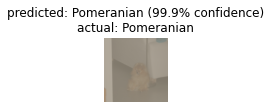

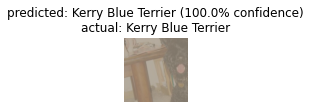

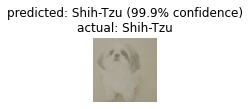

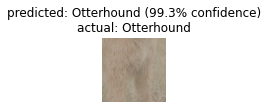

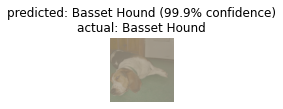

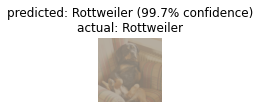

In [40]:
visualize_model(model_conv)

plt.ioff()
plt.show()